In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-jan-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-jan-2022/train.csv
/kaggle/input/tabular-playground-series-jan-2022/test.csv


In [160]:
!pip uninstall statsmodels -y
!pip install -U statsmodels

Found existing installation: statsmodels 0.13.1
Uninstalling statsmodels-0.13.1:
  Successfully uninstalled statsmodels-0.13.1
  Using cached statsmodels-0.13.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.8 MB)


In [161]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [162]:
from pathlib import Path
path = Path().cwd().parent / 'input'
files = list(path.rglob('*'))
files

[PosixPath('/kaggle/input/tabular-playground-series-jan-2022'),
 PosixPath('/kaggle/input/tabular-playground-series-jan-2022/sample_submission.csv'),
 PosixPath('/kaggle/input/tabular-playground-series-jan-2022/train.csv'),
 PosixPath('/kaggle/input/tabular-playground-series-jan-2022/test.csv')]

In [163]:
train = pd.read_csv(files[2])
test = pd.read_csv(files[3])
train
test

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911
...,...,...,...,...,...,...
26293,26293,2018-12-31,Sweden,KaggleMart,Kaggle Hat,823
26294,26294,2018-12-31,Sweden,KaggleMart,Kaggle Sticker,250
26295,26295,2018-12-31,Sweden,KaggleRama,Kaggle Mug,1004
26296,26296,2018-12-31,Sweden,KaggleRama,Kaggle Hat,1441


,row_id,date,country,store,product
0,26298,2019-01-01,Finland,KaggleMart,Kaggle Mug
1,26299,2019-01-01,Finland,KaggleMart,Kaggle Hat
2,26300,2019-01-01,Finland,KaggleMart,Kaggle Sticker
3,26301,2019-01-01,Finland,KaggleRama,Kaggle Mug
4,26302,2019-01-01,Finland,KaggleRama,Kaggle Hat
...,...,...,...,...,...
6565,32863,2019-12-31,Sweden,KaggleMart,Kaggle Hat
6566,32864,2019-12-31,Sweden,KaggleMart,Kaggle Sticker
6567,32865,2019-12-31,Sweden,KaggleRama,Kaggle Mug
6568,32866,2019-12-31,Sweden,KaggleRama,Kaggle Hat


In [164]:
# Categoricals

for col in train[['country', 'store', 'product']]:
    f'{col}, {train[col].unique()}'

"country, ['Finland' 'Norway' 'Sweden']"

"store, ['KaggleMart' 'KaggleRama']"

"product, ['Kaggle Mug' 'Kaggle Hat' 'Kaggle Sticker']"

In [165]:
# Datasets

dfs = {}
for cat in train['country'].unique():
    for cat_ in train['store'].unique():
        for cat__ in train['product'].unique():
            mask = (train['country']==cat) & (train['store']==cat_) & (train['product']==cat__)
            dfs[cat+cat_+cat__] = train[mask]

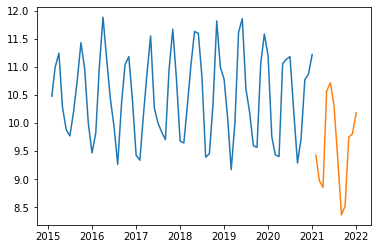

In [187]:
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from math import sin
from random import random
import matplotlib.pyplot as plt

num = 12*6
idx =pd.date_range(start='1-1-2015', freq='M', periods=num)
temp = pd.Series([sin(x)+random()+10 for x in range(num)], index=idx)
res = STLForecast(temp, ARIMA, model_kwargs={'order': (1,2,0)}, robust=True).fit()
forec = res.forecast(12)

fig, ax = plt.subplots()
_ = ax.plot(temp)
_ = ax.plot(forec)

In [ ]:
from random import randint
from itertools import cycle
from time import monotonic
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from deap import creator as ga_cr, base as ga_b, algorithms as ga_algo, tools as ga_t

class GA_Scikit():
    def __init__(self, estimator, params, eval_func, eval_weights, X_train, 
                 X_test, y_train, y_test, score, sel_tournsize=2, cx_uniform_prob=0.5, 
                 mut_shuffle_idx_prob=0.1, n_pop=25, n_gen=10, n_hof=3, cx_prob=0.5, 
                 mut_prob=0.1, n_jobs=4):
        self.est = estimator
        self.params = params
        self.eval_func = eval_func
        self.eval_weights = eval_weights
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.score = score
        self.sel_tournsize = sel_tournsize
        self.cx_uniform_prob = cx_uniform_prob
        self.mut_shuffle_idx_prob = mut_shuffle_idx_prob
        self.n_pop = n_pop
        self.n_gen = n_gen
        self.n_hof = n_hof
        self.cx_prob = cx_prob
        self.mut_prob = mut_prob
        self.n_jobs = n_jobs
        
        self._pad_params()
        self._create_fitness_and_indiv()
        self._register_indiv_and_pop_generators()
        self._register_eval_func()
        self._register_selection_crossover_mutation_methods()
        
    def _pad_params(self):
        """Pad params for crossover shuffle idx method"""
        assert isinstance(self.params, dict), 'Params must be a dict, i.e. estimator.get_params()'
        params_count = {k: len(v) for k,v in self.params.items()}
        max_length, max_key = -99, ''
        for k, v in params_count.items():
            if v <= max_length:
                continue
            else:
                max_key = k
                max_length = v
        assert isinstance(max_length, int), 'The max length between all params must be an int'
        # cycle through params for max length param, otherwise infinite cycle
        values_padded = (cycle(v) if k!=max_key else v for k,v in self.params.items())
        values_padded = zip(*values_padded)  # ('a', 1, 14), ('b', 2, 16), ('c', 3, 16) ...
        values_padded = zip(*values_padded)  # ('a', 'b', 'c'), (1, 2, 3), (14, 15, 16)...
        padded_params = {}
        for k, v in zip(self.params, values_padded):
            padded_params[k] = v
        self.padded_params = padded_params
        
    def _create_fitness_and_indiv(self):
        """Create GA individual and fitness entities (classes)"""
        ga_cr.create('Fitness', ga_b.Fitness, weights=self.eval_weights)
        ga_cr.create('Individual', list, fitness=ga_cr.Fitness)

    def _gen_params_to_ga(self):
        """Generate index for each param for individual"""
        max_dict = len(self.padded_params)
        max_length = len(list(self.padded_params.values())[0])
        idxs = [randint(0, max_length-1) for _ in range(max_dict)]
        return idxs
            
    def _register_indiv_and_pop_generators(self):
        """Register GA individual and population generators"""
        self.tb = ga_b.Toolbox()

        if self.n_jobs > 1:
            from multiprocessing import Pool
            pool = Pool()
            self.tb.register("map", pool.map)

        self.tb.register("individual", ga_t.initIterate, ga_cr.Individual, self._gen_params_to_ga)
        self.tb.register("population", ga_t.initRepeat, list, self.tb.individual)
    
    def _register_eval_func(self):
        """Set GA evaluate individual function"""
        self.tb.register("evaluate",
                        self.eval_func,
                        padded_params=self.padded_params,
                        est=self.est,
                        X_train=self.X_train,
                        X_test=self.X_test, 
                        y_train=self.y_train, 
                        y_test=self.y_test,
                        score=self.score)
        
    def _register_selection_crossover_mutation_methods(self):
        self.tb.register("select", ga_t.selTournament, tournsize=self.sel_tournsize)
        self.tb.register("mate", ga_t.cxUniform, indpb=self.cx_uniform_prob)
        self.tb.register("mutate", ga_t.mutShuffleIndexes, indpb=self.mut_shuffle_idx_prob)
        
    def run_ga_search(self):
        pop = self.tb.population(n=self.n_pop)
        hof = ga_t.HallOfFame(self.n_hof)

        # Stats stdout
        stats1 = ga_t.Statistics(lambda ind: ind.fitness.values[0] )
        stats2 = ga_t.Statistics(lambda ind: ind.fitness.values[1] )
        stats3 = ga_t.Statistics(lambda ind: ind.fitness.values[2] )
        stats = ga_t.MultiStatistics(score=stats1, duration=stats2, risk=stats3)
        stats.register("avg", np.mean)
        #stats.register("std", np.std)
        #stats.register("min", np.min)
        #stats.register("max", np.max)

        # History
        #hist = tools.History()
        #toolbox.decorate("select", hist.decorator)
        #tb.decorate("mate", hist.decorator)
        #tb.decorate("mutate", hist.decorator)
        #hist.update(pop)

        # GA Run
        pop, log = ga_algo.eaSimple(pop, self.tb, cxpb=self.cx_prob, 
                                    mutpb=self.mut_prob, ngen=self.n_gen, 
                                    stats=stats, halloffame=hof, verbose=True)
        
        # Convert back params
        hof_ = {}
        for i in range(self.n_hof):
            hof_['hof_' + str(i)] = self._ga_to_params(hof[i])

        return pop, log, hof_
    
    def _ga_to_params(self, idx_params):
        res = {}
        for (k,v), idx in zip(self.padded_params.items(), idx_params):
            res[k] = v[idx]
        return res

In [ ]:
f = RandomForestClassifier()

rf_params = {
            'class_weight': ['balanced', 'balanced_subsample'],
            'bootstrap': [False, True],
            'n_estimators': np.linspace(1, 100, 100).astype(int),
            'max_depth': np.linspace(1, 100, 100).astype(int),
            'criterion': ['gini', 'entropy'],
            'max_features': np.linspace(.01, .99, 100),
            'max_samples': np.linspace(.01, .99, 100),
             }

def rf_eval_indiv(individual, padded_params, est, X_train, X_test, y_train, y_test, score):
    """Evaluate individual's genes (estimator's params)"""
    ### => Result tuple must match weights in GA
    indiv_params = {k : list(v)[idx] for (k,v), idx in zip(padded_params.items(), individual)}
    est.set_params(**{**indiv_params, **{'n_jobs': 1} })  # seems can't parallelize this simultaneous with GA
    est.fit(X_train, y_train)
    start = monotonic()
    pred = est.predict(X_test)
    obj2 = monotonic() - start
    obj1 = score(y_test, pred)
    pred_proba = est.predict_proba(X_test)
    obj3 = float(np.quantile(pred_proba.prod(axis=1), 0.5))
    return (obj1, obj2, obj3)
        
eval_weights = (1, -1, -1)
# sel_tournsize, cx_uniform_prob, mut_shuffle_idx_prob = 2, 0.5, 0.1
# n_pop, n_gen, n_hof = 5, 5, 3
# cx_prob, mut_prob = 0.5, 0.1

ga_params = GA_Scikit(rf, 
                  rf_params, 
                  rf_eval_indiv, 
                  eval_weights,
                  X_train_transf,
                  X_test_transf,
                  y_train,
                  y_test,
                  accuracy_score,
                  #sel_tournsize,
                  #cx_uniform_prob,
                  #mut_shuffle_idx_prob,
                  #n_pop,
                  #n_gen,
                  #n_hof,
                  #cx_prob,
                  #mut_prob
                  )
pop, log, hof = ga_params.run_ga_search()
hof

In [158]:
!conda list statsmodels

# packages in environment at /opt/conda:
#
# Name                    Version                   Build  Channel
statsmodels               0.12.2                   pypi_0    pypi


2015-01-31    10.236409
2015-02-28    11.379237
2015-03-31    11.398501
2015-04-30    10.575964
2015-05-31     9.907102
                ...    
2020-08-31     9.611569
2020-09-30     9.946288
2020-10-31    10.491825
2020-11-30    10.979775
2020-12-31    11.360785
Freq: M, Length: 72, dtype: float64

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.02404D-01    |proj g|=  2.67777D-03

At iterate    5    f=  6.02394D-01    |proj g|=  3.42740D-03

At iterate   10    f=  6.02393D-01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     12      1     0     0   0.000D+00   6.024D-01
  F =  0.60239256936697472     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [ ]:
if False:
    res = ARIMA(temp, (2,2,0)).fit(disp=0)
    forec_periods = 24
    forec, stderr, conf_int = res.forecast(forec_periods)
    forec = pd.Series(forec, index=[temp.index.max()+pd.DateOffset(months=i+1) for i in range(forec_periods)])
    forec

    fig, ax = plt.subplots(figsize=(12,6))
    _ = ax.plot(temp)
    _ = ax.plot(forec)